In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class FacialExpressionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(FacialExpressionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 28 * 28, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256 * 28 * 28)
        x = self.dropout(x)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.fc2(x)
        return x

In [3]:
data_dir = 'datasets/dataset1/train'  # Path to your dataset

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match your model's expected input dimension
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [4]:
# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FacialExpressionCNN(num_classes=7).to(device)  # Update num_classes based on your dataset
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

import matplotlib.pyplot as plt

# Initialize lists to store per-epoch loss
train_losses = []
val_losses = []

num_epochs = 50  # Or any other number of epochs you're using
patience = 5
best_val_loss = np.Inf
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate average losses
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
    
    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

Epoch 1, Train Loss: 1.6339291003753216, Validation Loss: 1.49064325955179
Epoch 2, Train Loss: 1.348584070926257, Validation Loss: 1.374757894873619
Epoch 3, Train Loss: 1.120486446160792, Validation Loss: 1.3138778371943367
Epoch 4, Train Loss: 0.8767030000437601, Validation Loss: 1.3841710074080362
Epoch 5, Train Loss: 0.6095115957485933, Validation Loss: 1.4842475576533212
Epoch 6, Train Loss: 0.3724275134026506, Validation Loss: 1.6317102819681168
Epoch 7, Train Loss: 0.2498487754255367, Validation Loss: 1.8291004647811253
Epoch 8, Train Loss: 0.18989841835858678, Validation Loss: 1.8981211294730505
Early stopping triggered


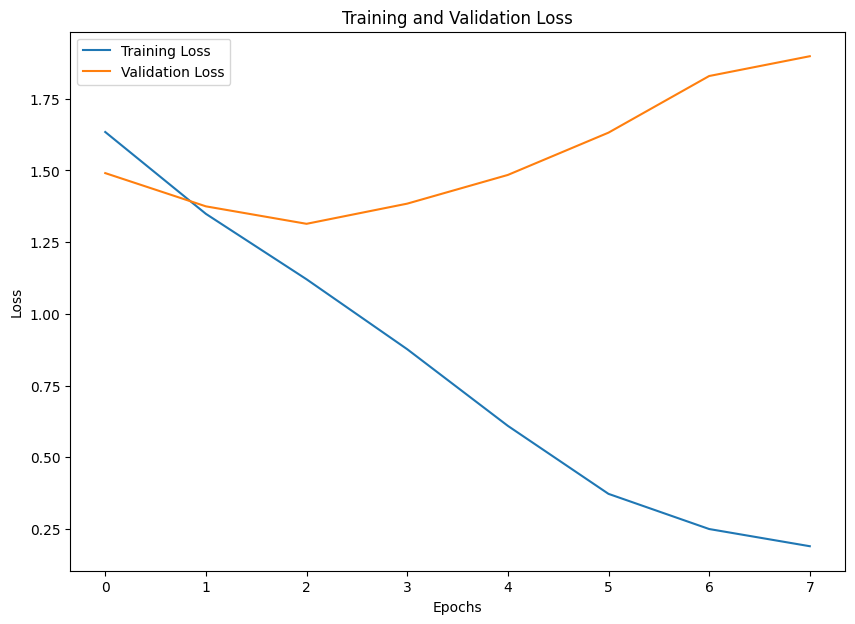

In [8]:
import matplotlib.pyplot as plt
# Load the best model weights
model.load_state_dict(best_model_wts)

# Plotting training and validation loss
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [9]:
model_path = 'cnn.pth'
torch.save(model.state_dict(), model_path)